In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact_manual
import ipywidgets as wd

from math import floor, log10
from os import system

''' GLOBAL CONSTANTS '''
PI = 3.141592
BOLTZMANN = 1.380649E-23 #N·m/K
TEMP = 10 + 273.15 #K
g = 9.81 #m/s²


def sci_notation(num, decimal_digits=1, precision=None, exponent=None):
    """
    Returns a string representation of the scientific
    notation of the given number formatted for use with
    LaTeX or Mathtext, with specified number of significant
    decimal digits and precision (number of decimal digits
    to show). The exponent to be used can also be specified
    explicitly.
    """
    if exponent is None:
        exponent = int(floor(log10(abs(num))))
    coeff = round(num / float(10**exponent), decimal_digits)
    if precision is None:
        precision = decimal_digits

    return r"${0:.{2}f}\times10^{{{1:d}}}$".format(coeff, exponent, precision)

def p_notation(num) -> str:
    exponent = np.log10(num)
    return rf"$10^{{{exponent:.0f}}}$"

In [2]:
def dispCoef(D_m,alpha_L,U,n=1.0):
    return D_m + alpha_L*(U**n)

def poreVel(q, theta):
    return q/theta

def molecularDiff(visco,dp): 
    return (BOLTZMANN*TEMP)/(3*PI*visco*dp)

def attachmentRate(dc,theta,alpha,U,eta0): 
    return (3*(1-theta)*alpha*U*eta0)/(2*dc)

def collectorEff(etaD,etaI,etaG):
    return etaD + etaI + etaG

def collectorEfficiency_Diffusion(A_s,N_R,N_Pe,N_vdW):
    return 2.40 * (A_s**(1./3.)) * (N_R**-0.081) * (N_Pe**-0.715) * (N_vdW**0.052)

def collectorEfficiency_Interception(A_s,N_R,N_Pe,N_vdW):
    return 0.55 * A_s * (N_R**1.55) * (N_Pe**-0.125) * (N_vdW**0.125)

def collectorEfficiency_GDeposition(N_gr,N_R,N_Pe,N_vdW):
    return 0.475 * (N_gr**1.11)   * (N_R**-1.35)  * (N_Pe**-1.11)  * (N_vdW**0.053)

def happelParameter(theta):
    s = 1-theta
    s53 = s**(5./3.)
    s13 = s**(1./3.)
    s21 = s**2
    return (2*(1-s53))/(2 - (3*s13) + (3*s53) - (2*s21))

def noDim_SizeRatio(dp,dc):
    return dp/dc

def noDim_Péclet(q,dc,Dm):
     return q*dc/Dm

def noDim_vanderWaals(A):
    return A/(BOLTZMANN*TEMP)

def noDim_Gravitational(dp,rhof,rhop):
    return (PI*(dp**4)*(rhop-rhof)*g)/(12.*BOLTZMANN*TEMP)

In [3]:
'''CASE CONSTANTS'''
#Porosity
theta = 0.35 # adim
dc = 2.0E-3 # 2mm << sand
dp = 1.0E-7
A = 5.0E-21 # J = N·m
viscosity = 0.0008891 # N·s/m²
water_density = 999.79 # kg/m³
particle_density = 1050.0 # kg/m³ 
alpha = 0.01 # adim << favorable conditions

#Darcy flow velocity
I = np.power(10.0, np.arange(-5,0,0.1))
H = 20.
r = 40.
f = 10.
Qin = 0.24/86400.
decayRate = 3.5353E-06

In [4]:
def hydraulicCond_kozenycarman(dc:np.array) -> np.array:
    kappa = dc**2 * np.power(theta,3)/ (180 * np.power(1-theta, 2))
    return kappa * water_density * g / viscosity

K = hydraulicCond_kozenycarman(dc)

In [5]:
def characteristic_q(I:np.array) -> np.array:
    return K*I + Qin*(1+f)/(4*r*H)

q = characteristic_q(I)

In [6]:
def katt_dp_dc(dp:np.array, dc:np.array, q:np.array):

    #Molecular diffusion
    Dm  = molecularDiff(viscosity,dp)
    
    #Pore water velocity
    U   = poreVel(q,theta)
    
    #Non-dimensional numbers
    As  = happelParameter(theta)
    NR  = noDim_SizeRatio(dp,dc)
    NPe = noDim_Péclet(q,dc,Dm)
    NvW = noDim_vanderWaals(A)
    NGr = noDim_Gravitational(dp,water_density,particle_density)
    
    #Collector efficiency
    etaD = collectorEfficiency_Diffusion(As,NR,NPe,NvW)
    etaI = collectorEfficiency_Interception(As,NR,NPe,NvW)
    etaG = collectorEfficiency_GDeposition(NGr,NR,NPe,NvW)
    eta0 = collectorEff(etaD,etaI,etaG)
    
    #Attachment rate
    kAtt = attachmentRate(dc,theta,alpha,U,eta0)

    return kAtt

katt = katt_dp_dc(dp,dc,q)

In [7]:
tau = (r*theta)/q
deltay = 1.35
Ce = {
    "Combined"  : Qin/(q*deltay*H) * np.exp(-(decayRate + katt)*tau),
    "Filtration"   : np.exp(-(katt)*tau),
    "Inactivation" : np.exp(-(decayRate)*tau),
    "Dilution" : Qin/(q*deltay*H) }

In [8]:
import matplotlib.colors as colors
import matplotlib.ticker as ticker
plt.style.use(f'/home/edsaa/Repositories/ReactiveBiomass/misc/edwin.mplstyle')

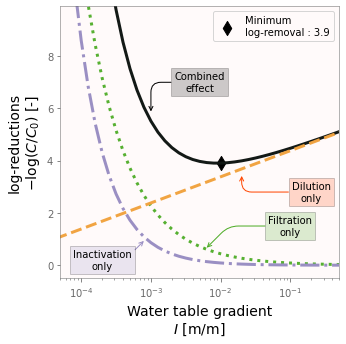

In [9]:
fig, ax = plt.subplots(1,1,figsize=(5,5)) 

ax.plot(I, -np.log10(Ce["Combined"]), 
    lw=3, c='#101613',alpha=0.99, zorder=2)

ax.plot(I, -np.log10(Ce["Filtration"]),
    lw=3,ls="dotted",alpha=0.95, c="#4dac26")

ax.plot(I, -np.log10(Ce["Inactivation"]),
    lw=3,ls="dashdot",alpha=0.99, c='#998ec3')

ax.plot(I, -np.log10(Ce["Dilution"]),
    lw=3,ls="dashed",alpha=0.99, c='#f1a340')
    
#ax.legend()
ax.set_xscale('log')
ax.set(xlim=(5.0E-5,5.0E-1),ylim=(-0.5,9.9))

ax.annotate('Combined\neffect', 
    xy=(1E-3, 5.5), 
    xytext=(5e-3, 7.0), xycoords='data', 
    fontsize=10, ha='center', va='center',
    bbox=dict(boxstyle='square', fc='black',alpha=0.20),
    arrowprops=dict(arrowstyle="->",
            shrinkA=0, shrinkB=10,
            connectionstyle="angle,angleA=0,angleB=90,rad=10"))

ax.annotate('Filtration\nonly', 
    xy=(5E-3, 0.4), 
    xytext=(1e-1, 1.5), xycoords='data', 
    fontsize=10, ha='center', va='center',
    bbox=dict(boxstyle='square', fc='#4dac26',alpha=0.20),
    arrowprops=dict(arrowstyle="->",
            shrinkA=0, shrinkB=10, ec="#4dac26",
            connectionstyle="angle,angleA=0,angleB=45,rad=10"))

ax.annotate('Inactivation\nonly', 
    xy=(1E-3, 1.2), 
    xytext=(2e-4, 0.2), xycoords='data', 
    fontsize=10, ha='center', va='center',
    bbox=dict(boxstyle='square', fc='#998ec3',alpha=0.20),
    arrowprops=dict(arrowstyle="->",
            shrinkA=0, shrinkB=10, ec='#998ec3',
            connectionstyle="angle,angleA=0,angleB=45,rad=10"))

ax.annotate('Dilution\nonly', 
    xy=(2E-2, 3.8), 
    xytext=(2e-1, 2.8), xycoords='data',  
    fontsize=10, ha='center', va='center',
    bbox=dict(boxstyle='square', fc='orangered',alpha=0.20),
    arrowprops=dict(arrowstyle="->",
            shrinkA=0, shrinkB=10, ec='orangered',
            connectionstyle="angle,angleA=0,angleB=90,rad=10"))

ax.set_xlabel("Water table gradient\n$I$ [m/m]")
ax.set_ylabel("log-reductions\n$-\log(C/C_0)$ [-]")
ax.spines.top.set_visible(True)

Imin, Cemin = I[np.argmax(Ce["Combined"])], -np.log10(Ce["Combined"].max())

ax.scatter(Imin,Cemin, s=100, marker="d",
    label=f"Minimum\nlog-removal : {Cemin:.1f}")
ax.legend(fontsize=10)
plt.show()